# ADS 509 Module 3: Group Comparison 

**Lorena Dorado**

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Use this space for any additional import statements you need
import pandas as pd
from collections import Counter
from typing import List, Dict, Set
from itertools import combinations

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

TITLE_PATTERN = re.compile(r"^\[.*?\]|\(.*?\)")  # For removing song titles

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# Functions


def remove_song_titles(text: str) -> str:
    """Remove song titles in brackets or parentheses."""
    return TITLE_PATTERN.sub('', text).strip()


def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    
    if verbose :
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the data.")
        
        # print the five most common tokens using Counter
        most_common = Counter(tokens).most_common(5)
        print(f"\nThe five most common tokens:")
        for token, count in most_common:
            print(f"  {token}: {count}")

    return([len(tokens),
        len(set(tokens)),
        len("".join(tokens)),
        len(set(tokens))/len(tokens)])
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    # return(tokens)
    return [token for token in tokens if token.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def remove_unwanted_tokens(tokens: List[str]) -> List[str]:
    """Remove unwanted tokens like 'nan', 'null', etc."""
    unwanted = {'nan', 'null'}  # Add any other unwanted tokens
    return [token for token in tokens if token.lower() not in unwanted]

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    # return(text)
    tokens = whitespace_pattern.split(text.strip()) # split on whitespace
    tokens = [token for token in tokens if token] # filter out empty tokens
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "M1 Assignment Data/M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [8]:
# read in the lyrics here
lyrics_data = defaultdict(dict)
for item in os.listdir(data_location + lyrics_folder) :
    if os.path.isdir(data_location + lyrics_folder + item) :
        for lyric_page in os.listdir(data_location + lyrics_folder + item) :
            artist,song = lyric_page.split("_")
            song = song.replace(".txt","")
            lyrics_data[item][song] = open(data_location + lyrics_folder + item + "/" + lyric_page).read()

In [9]:
# pandas DataFrame
lyrics_data = pd.DataFrame([
    {
        'artist': artist,
        'song': song,
        'lyrics': lyrics
    }
    for artist in lyrics_data
    for song, lyrics in lyrics_data[artist].items()
])

In [10]:
lyrics_data.head()

,artist,song,lyrics
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

- [x] Remove song titles
- [x] Casefold to lowercase
- [x] Remove stopwords (optional)
- [x] Remove punctuation
- [x] Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

- [x] Casefold to lowercase
- [x] Remove stopwords
- [x] Remove punctuation other than emojis or hashtags
- [x] Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [11]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

# my_lyrics_pipeline = [remove_song_titles, str.lower, remove_punctuation, tokenize, remove_stop]
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop, remove_unwanted_tokens]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [12]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [13]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
866137,cher,Love To Be Happy✌✌,"[love, happy✌✌]"
3310976,cher,"Voce di Radio Stop, la radio POP della Toscana 📻","[voce, di, radio, stop, la, radio, pop, della,..."
1062195,cher,howdy 🤠,"[howdy, 🤠]"
31897,cher,17 • Lesbian • She/they • ♌︎ ☉ • ♑︎ ☽ • ♏︎ ↑ •...,"[17, •, lesbian, •, shethey, •, ♌︎, ☉, •, ♑︎, ..."
983534,cher,Estudié arquitectura pero soy Entrenador Pokém...,"[estudié, arquitectura, pero, soy, entrenador,..."
233128,cher,"Playing piano, listening to music, swimming, l...","[playing, piano, listening, music, swimming, l..."
987550,cher,"Just out here hustling, flipping and living da...","[hustling, flipping, living, dat, yay, area, l..."
2381826,cher,13 Aberdeen @jhutch1992 ❤️,"[13, aberdeen, jhutch1992, ❤️]"
1796478,cher,22 He/They 🏳️‍🌈 • Chemistry at Pitt • Sheik ma...,"[22, hethey, 🏳️‍🌈, •, chemistry, pitt, •, shei..."
3731234,cher,I'm like an onion... I have layers. No? Wait l...,"[im, like, onion, layers, wait, let, rephrase,..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

**A: For text normalization, we can make the token counts more accurate by handling contractions that have the same meaning. For example, 'do not' and 'don't' should be counted together to reduce redundancy. By grouping words that have the same meaning, it can improve analysis for a more cohesive representation of the language. This can also improve performance in machine learning classification and sentiment analysis.**

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [14]:
# your code here
# Group tokens by artist and flatten them
lyrics_tokens = lyrics_data.groupby('artist')['tokens'].apply(lambda x: [token for tokens_list in x for token in tokens_list])

# Calculate and print descriptive statistics for each artist
for artist, tokens in lyrics_tokens.items():
    print(f"\nDescriptive Statistics for Artist: {artist}")
    lyrics_stats = descriptive_stats(tokens)


Descriptive Statistics for Artist: cher
There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172696 characters in the data.
The lexical diversity is 0.103 in the data.

The five most common tokens:
  love: 1004
  im: 513
  know: 486
  dont: 440
  youre: 333

Descriptive Statistics for Artist: robyn
There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73988 characters in the data.
The lexical diversity is 0.142 in the data.

The five most common tokens:
  know: 308
  dont: 301
  im: 299
  love: 275
  got: 251


In [15]:
lyrics_data.head()

,artist,song,lyrics,tokens,num_tokens
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",182
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",137
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",120
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ...",34
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",67


Q: what observations do you make about these data? 

**A: These patterns appear to have differences between the artists' music styles while also having common language used in pop culture. Cher has a larger corpus (35,916) compared to Robyn (15,227). Cher also has more unique tokens than Robyn. They have some similar common tokens, including "love", "im", "know", and "dont". Robyn has a higher lexical diversity (0.142), suggesting that the artist uses diverse vocabulary relative to the corpus size. This is interesting because Cher's lexical diversity is 0.103, even though she has a larger corpus.**

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [16]:
# Analyze tokens across all four corpora to find distinctive tokens
def analyze_all_corpora(lyrics_data: pd.DataFrame, twitter_data: pd.DataFrame, min_frequency: int = 5) -> pd.DataFrame:
    # Extract tokens for each corpus
    cher_lyrics = []
    robyn_lyrics = []
    cher_twitter = []
    robyn_twitter = []
    
    # Populate lyrics corpora
    for _, row in lyrics_data.iterrows():
        if row['artist'].lower() == 'cher':
            cher_lyrics.extend(row['tokens'])
        else:
            robyn_lyrics.extend(row['tokens'])
    
    # Populate twitter corpora
    for _, row in twitter_data.iterrows():
        if row['artist'].lower() == 'cher':
            cher_twitter.extend(row['tokens'])
        else:
            robyn_twitter.extend(row['tokens'])
    
    # Create counters for each corpus
    counters = {
        "Cher Lyrics": Counter(cher_lyrics),
        "Robyn Lyrics": Counter(robyn_lyrics),
        "Cher Twitter": Counter(cher_twitter),
        "Robyn Twitter": Counter(robyn_twitter)
    }
    
    # Get total tokens in each corpus
    totals = {
        name: sum(counter.values()) 
        for name, counter in counters.items()
    }
    
    # Get all unique tokens
    all_tokens = set().union(*[set(counter.keys()) for counter in counters.values()])
    
    # Filter tokens that appear at least min_frequency times in all corpora
    qualified_tokens = {
        token for token in all_tokens
        if all(counters[corpus][token] >= min_frequency for corpus in counters)
    }
    
    # Calculate statistics for qualified tokens
    data = []
    for token in qualified_tokens:
        # Calculate frequency ratios for each corpus vs others
        for corpus_name in counters:
            # Frequency in this corpus
            freq_this = counters[corpus_name][token] / totals[corpus_name]
            
            # Average frequency in other corpora
            other_freqs = [
                counters[other][token] / totals[other]
                for other in counters if other != corpus_name
            ]
            avg_freq_others = sum(other_freqs) / len(other_freqs)
            
            # Calculate ratio (add small constant to prevent division by zero)
            ratio = freq_this / (avg_freq_others + 1e-10)
            
            data.append({
                'Token': token,
                'Corpus': corpus_name,
                'Count': counters[corpus_name][token],
                'Total Tokens': totals[corpus_name],
                'Frequency': freq_this,
                'Ratio vs Others': ratio
            })
    
    # Create DataFrame and get top 10 tokens for each corpus
    df = pd.DataFrame(data)
    
    # Sort by ratio and get top 10 for each corpus
    top_tokens = (df.sort_values('Ratio vs Others', ascending=False)
                   .groupby('Corpus')
                   .head(10)
                   .sort_values(['Corpus', 'Ratio vs Others'], ascending=[True, False]))
    
    # Format numbers
    top_tokens['Frequency'] = top_tokens['Frequency'].map('{:.2%}'.format)
    top_tokens['Ratio vs Others'] = top_tokens['Ratio vs Others'].map('{:.2f}'.format)
    
    return top_tokens

# Add summary statistics
def print_corpus_stats(lyrics_data: pd.DataFrame, twitter_data: pd.DataFrame) -> None:
    """Print summary statistics for each corpus"""
    print("Corpus Statistics:")
    print("-" * 50)
    
    # Lyrics stats
    cher_lyrics = sum(len(row['tokens']) for _, row in lyrics_data[lyrics_data['artist'].str.lower() == 'cher'].iterrows())
    robyn_lyrics = sum(len(row['tokens']) for _, row in lyrics_data[lyrics_data['artist'].str.lower() != 'cher'].iterrows())
    
    # Twitter stats
    cher_twitter = sum(len(row['tokens']) for _, row in twitter_data[twitter_data['artist'].str.lower() == 'cher'].iterrows())
    robyn_twitter = sum(len(row['tokens']) for _, row in twitter_data[twitter_data['artist'].str.lower() != 'cher'].iterrows())
    
    print(f"Cher Lyrics: {cher_lyrics:,} tokens")
    print(f"Robyn Lyrics: {robyn_lyrics:,} tokens")
    print(f"Cher Twitter: {cher_twitter:,} tokens")
    print(f"Robyn Twitter: {robyn_twitter:,} tokens\n")

# Print dataFrame with token comparison statistics
print_corpus_stats(lyrics_data, twitter_data)
results = analyze_all_corpora(lyrics_data, twitter_data, min_frequency=5)
print("\nTop 10 Distinctive Tokens by Corpus:")
print("-" * 80)
print(results.to_string(index=False))

Corpus Statistics:
--------------------------------------------------
Cher Lyrics: 35,916 tokens
Robyn Lyrics: 15,227 tokens
Cher Twitter: 15,673,611 tokens
Robyn Twitter: 1,495,758 tokens


Top 10 Distinctive Tokens by Corpus:
--------------------------------------------------------------------------------
     Token        Corpus  Count  Total Tokens Frequency Ratio vs Others
      walk   Cher Lyrics    118         35916     0.33%           16.83
     tears   Cher Lyrics     57         35916     0.16%           11.76
    enough   Cher Lyrics    129         35916     0.36%           11.31
     knock   Cher Lyrics     36         35916     0.10%            8.51
    strong   Cher Lyrics     77         35916     0.21%            7.39
   without   Cher Lyrics     88         35916     0.25%            7.28
       hes   Cher Lyrics     76         35916     0.21%            7.08
      door   Cher Lyrics     61         35916     0.17%            7.04
understand   Cher Lyrics     44         359

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

**A: For the lyrics content, Cher's lyrics have tokens like 'walk,' 'tears,' and 'hes,' which hint at emotional or narrative content. Compared to Robyn, whose tokens include 'beat,' 'dance,' and 'alright,' hinting at a more dance-pop vibe. Robyn's 'beat' has the highest ratio overall (39.22).**

**For Cher's Twitter content, 'proud,' 'god,' and 'happy' are emotional words that suggest spiritual or personal content. Robyn, on the other hand, has words like 'working,' 'best,' and 'things,' which could suggest career or promotional tweets. Twitter tokens appear to have lower ratios, under 4.0. Furthermore, the large differences in corpus size could skew the distinctive metrics.**

**Both artists have 'news' and 'live,' possibly for further promotional campaigns. Interesting items on the list include 'men' in Robyn's Twitter corpus, possibly attracting gender topics.**

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [17]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

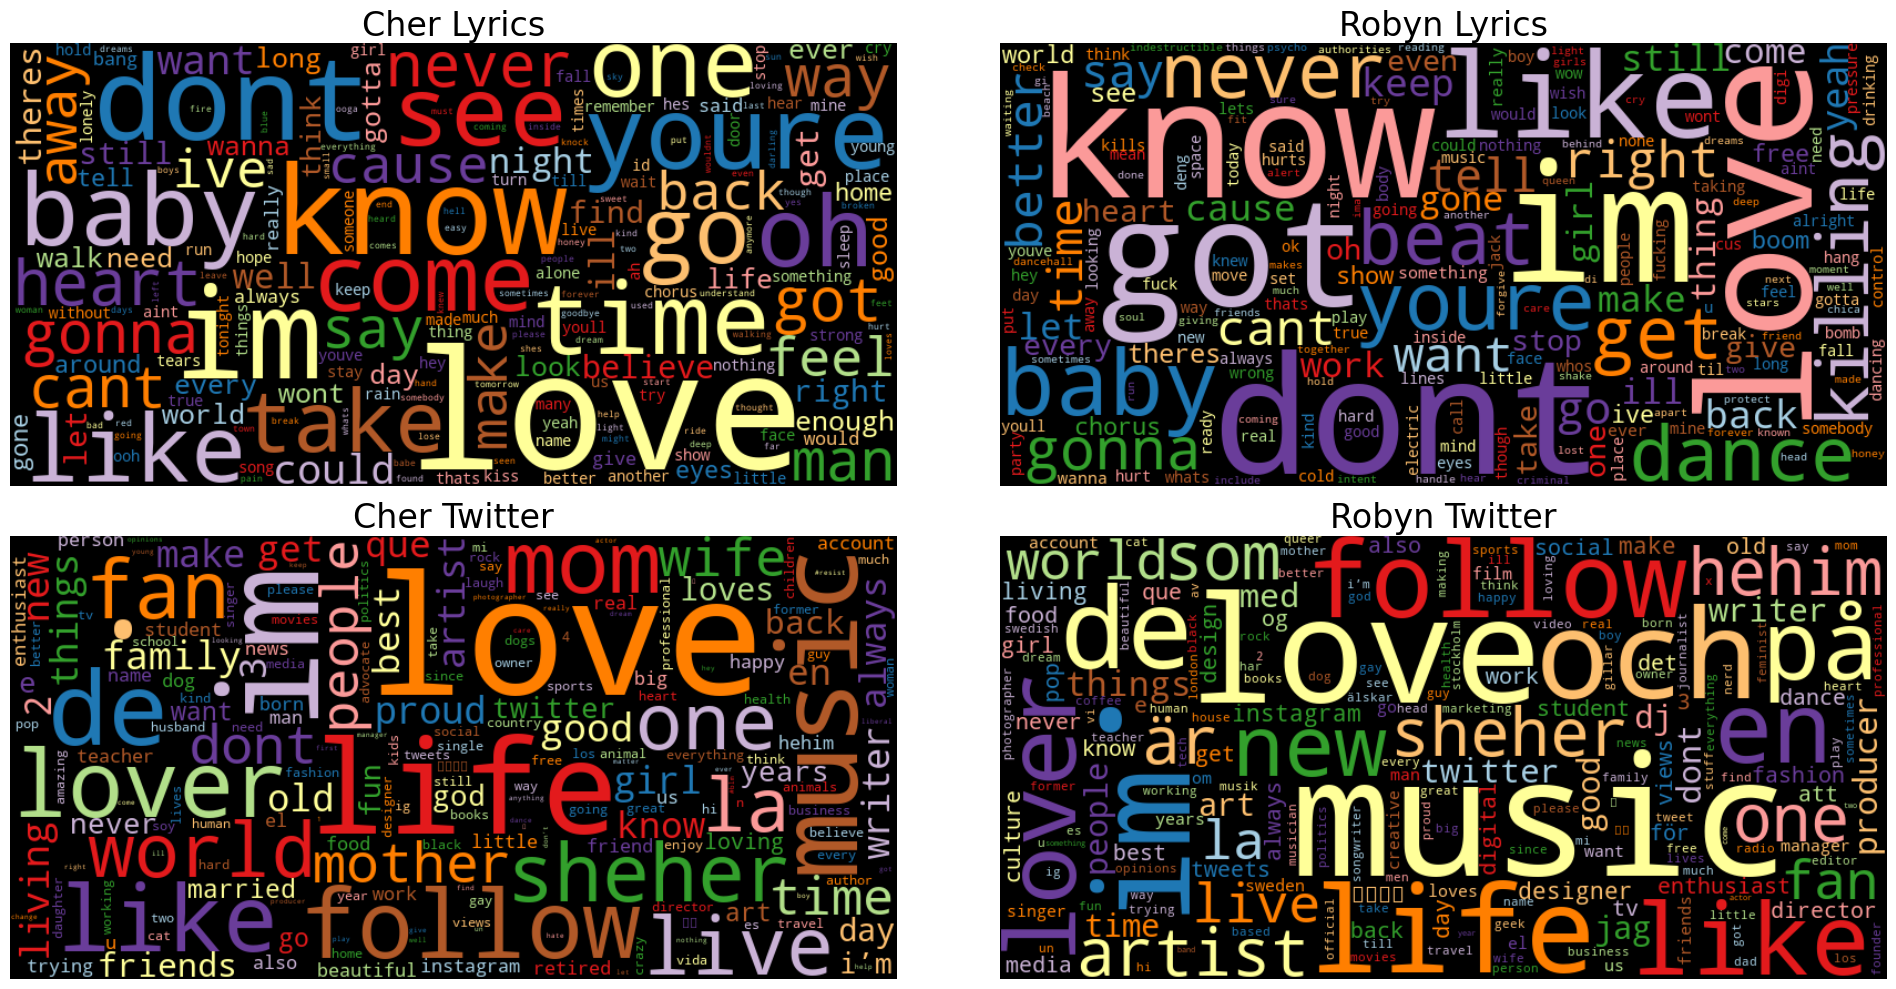

In [18]:
# Create wordcloud subplots
def create_wordcloud(data, artist, title, subplot_position, min_freq=5, title_fontsize=20):
    plt.subplot(2, 2, subplot_position)
    artist_data = data[data['artist'] == artist]
    word_freq = count_words(artist_data, min_freq=min_freq)
    wordcloud(word_freq['freq'])  # Generate wordcloud
    plt.title(title, fontsize=title_fontsize)  # Set the title with increased font size

# Create figure with subplots for all wordclouds
plt.figure(figsize=(20, 10))

# Generate wordclouds
create_wordcloud(lyrics_data, 'cher', "Cher Lyrics", 1, title_fontsize=24)
create_wordcloud(lyrics_data, 'robyn', "Robyn Lyrics", 2, title_fontsize=24)
create_wordcloud(twitter_data, 'cher', "Cher Twitter", 3, title_fontsize=24)
create_wordcloud(twitter_data, 'robyn', "Robyn Twitter", 4, title_fontsize=24)

plt.tight_layout()
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

**A: Both word clouds have a lot of words in common, including 'love' and 'dont.' I do see more foreign/international text in Robyn's Twitter. Overall, both artists strikingly display the common tokens as mentioned in the descriptive statistics. I do notice words in Cher's Twitter like 'mom,' 'wife,' and 'family.' The lyrics could be family-friendly. It is surprising not to see any negative words. I notice that both Twitter wordclouds include "follow" and "like" and that could be attributed to links in the platform and not tweet related.**

#### References

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly. 

OpenAI. (2025). ChatGPT (Version 4.0) [AI model]. OpenAI. https://openai.com/chatgpt